# Structure substitutive des pavages apériodiques de Jeandel-Rao

Sébastien Labbé, version 1 of [arXiv:1808.07768](http://arxiv.org/abs/1808.07768), August 2018

Sébastien Labbé, version 2 of [arXiv:1808.07768](http://arxiv.org/abs/1808.07768), April 2019

Sébastien Labbé, first online version in DCG, November 2019. We did changes to make the code work in Python 3 which is used in Sage starting from version 9.0.

Références:

 * A self-similar aperiodic set of 19 Wang tiles, Geometriae Dedicata, (2018)  
[doi:10.1007/s10711-018-0384-8](https://doi.org/10.1007/s10711-018-0384-8), [arXiv:1802.03265](http://arxiv.org/abs/1802.03265)
    
 * Substitutive structure of Jeandel-Rao aperiodic tilings, August 2018, 38 p.
[arXiv:1808.07768](http://arxiv.org/abs/1808.07768)

## Prerequisites

Sage version 8.7 or above should work:

In [1]:
version()

'SageMath version 9.0.beta6, Release Date: 2019-11-18'

The installation of the optional Sage package [slabbe](https://pypi.org/project/slabbe) is a prerequisite. Remove the dash sign (`#`) and evaluate the following cell to install slabbe optional package.

The installation of [graphviz](https://graphviz.org/) and of the optional Sage package dot2tex is a prerequisite to construct the graphs at the end of the notebook.

Finally, I am using [rise](https://rise.readthedocs.io/en/docs_hot_fixes/index.html) for the presentation and [tikzmagic](https://github.com/robjstan/tikzmagic) in Jupyter cells.

In [2]:
#!sage -pip install slabbe>=0.4.4
#!sage -pip install dot2tex
#!sage -pip install rise
#!sage -pip install git+git://github.com/robjstan/tikzmagic.git

## Choosing a solver

The time it takes to evaluate all cells of this notebook depend on the chosen available solver.

Solver | Type | Time to run this notebook
--- | --- | ---
*dancing_links* | Exact cover solver | about 2 minutes
*Gurobi* | MILP solver | about 4 minutes
*Glucose* | SAT solver | about 30 minutes (estimated)

The above timing were computed on a 2019 computer with 8 available cpus.
    
**Dancing links** is an algorithm proposed by D. Knuth to solve the Exact Cover Problem and is available in plain Sage.

**Gurobi** is a MILP solver. It is a proprietary software, but it is free for researchers and students. See this [tutorial to make Gurobi available through Sage](https://doc.sagemath.org/html/en/thematic_tutorials/linear_programming.html#using-cplex-or-gurobi-through-sage).

**Glucose** is a SAT solver developped at LaBRI (Bordeaux). It can be installed in sage>=8.7.beta0 easily:

    sage -i glucose

In [3]:
from sage.misc.package import is_package_installed
from sage.doctest.external import has_gurobi
if has_gurobi():
    solver = 'gurobi'
elif is_package_installed('glucose'):
    solver = 'glucose'
else:
    solver = 'dancing_links'
solver = 'dancing_links' # more time efficient
print("We are using solver = '{}'".format(solver))

We are using solver = 'dancing_links'


# Setup

Colors setup:

In [4]:
from collections import defaultdict
color = defaultdict(lambda : 'white')
color.update({0:'white', 1:'red', 2:'cyan', 3:'green', 4:'lightgray'})
color.update({str(k):v for k,v in color.items()})

Loading modules from slabbe and tikzmagic.

If needed, here is the command to install tikzmagic:

    sage -pip install git+git://github.com/robjstan/tikzmagic.git

In [5]:
from slabbe import WangTileSet, Substitution2d
import tikzmagic

Latex macros:

$\newcommand{T}{{\mathcal{T}}}$
$\newcommand{U}{{\mathcal{U}}}$
$\newcommand{N}{{\mathbb{N}}}$
$\newcommand{Z}{{\mathbb{Z}}}$
$\newcommand{R}{{\mathbb{R}}}$

## Definition of Jeandel-Rao Tiles $\mathcal{T}_0$

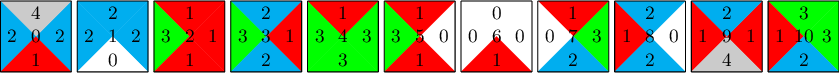

In [6]:
tiles = [(2,4,2,1), (2,2,2,0), (1,1,3,1), (1,2,3,2), (3,1,3,3), (0,1,3,1), (0,0,0,1), (3,1,0,2), (0,2,1,2), (1,2,1,4), (3,3,1,2)]
tiles = [[str(a) for a in t] for t in tiles]
T0 = WangTileSet(tiles)
T0.tikz(font=r'\small', size=1.2, ncolumns=11, color=color)

Let 
$$\Omega_0=\Omega_{\T_0}=\{w:\Z\times\Z\to\T_0\mid w \text{ is a valid Wang tiling}\}$$
be the set of tilings made with the 11 Jeandel-Rao tiles.

In [7]:
%time solution = T0.solver(30,15).solve(solver='glucose')

CPU times: user 248 ms, sys: 4 ms, total: 252 ms
Wall time: 478 ms


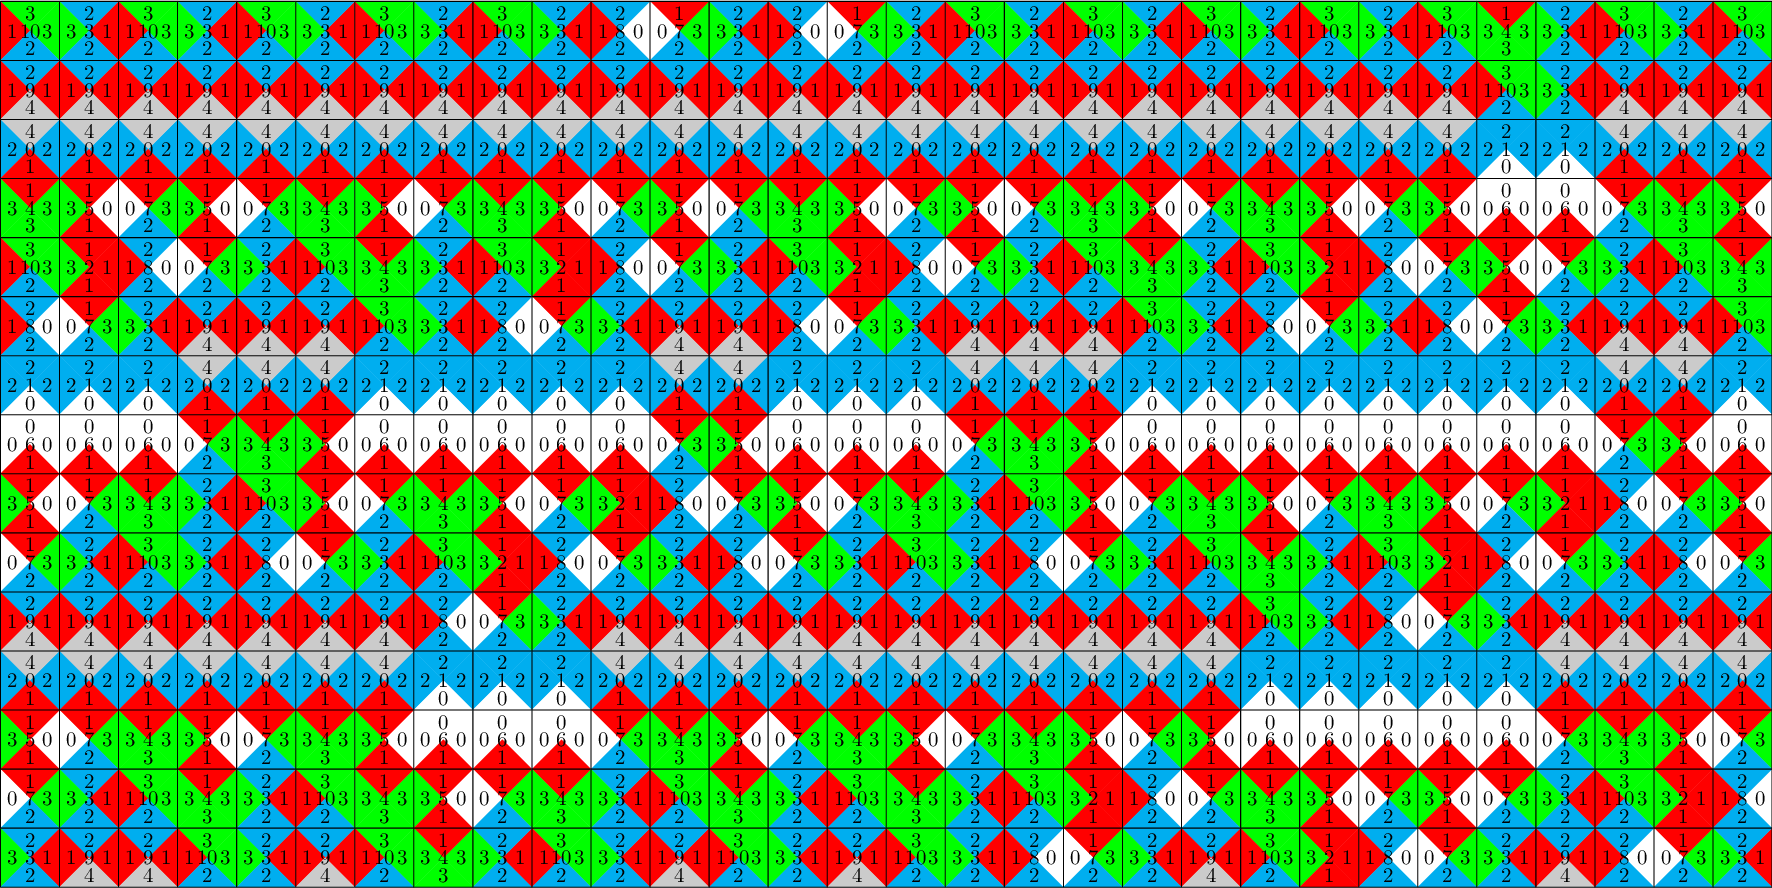

In [8]:
solution.tikz(color=color)

The substitutive structure of Jeandel-Rao tilings $\Omega_0$ looks like this:

In [9]:
%tikz -i subs-struct.tikz --no-wrap

The current Jupyter notebook computes 

* the Wang tile sets $\T_i$ for each $i\in\{1,\dots,12\}$
* the Wang shifts $\Omega_i=\Omega_{\T_i}=\{w:\Z\times\Z\to\T_i\mid w \text{ is a valid Wang tiling}\}$ for each $i\in\{1,\dots,12\}$
* the 2-dimensional morphisms $\omega_i:\Omega_{i+1}\to\Omega_i$ for each $i\in\{1,\dots,12\}\setminus\{4,5\}$
* the embedding $\pi:\Omega_5\to\Omega_4$
* the topological conjugacy $\eta:\Omega_6\to\Omega_5$

Algorithm.

INPUTS: $\T$ is a Wang tile set;
            $i\in\{1,2\}$ is a direction $e_i$;
            $r\in\N$ is some radius.
            
**FindMarkers**($\mathcal{T}$, $i$, $r$)
    
* $j\gets 3-i$
* $D_j \gets \left\{(u,v)\in\T^2\mid u\odot^jv\text{ admits a surrounding or radius } r\text{ in }\Omega_\T \right\}$
* $U \gets $**UnionFindDataStructure**$(\T)$
* **For All** $(u,v) \in D_j$
    - **Union**$(u, v)$ 
    (Merge $u$ and $v$ in the data structure $U$)
* **EndFor**
* $D_i \gets \left\{(u,v)\in\T^2\mid u\odot^iv \text{
     admits a surrounding or radius } r \text{ in }\Omega_\T\right\}$
* Return $\{S \in\textbf{Subsets}(U) \mid
                       \left(S\times S\right) \cap D_i=\varnothing\}$

* The output contains zero, one or more subsets of markers in the direction $i$.

## Computing $\mathcal{T}_1$

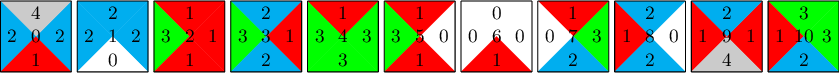

In [10]:
T0.tikz(font=r'\small', ncolumns=11, size=1.2, color=color)

In [11]:
%time T0.find_markers(i=2, radius=1, solver=solver) # 229ms with dancing_links, 32s with Glucose, 1.4s with Gurobi

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 258 ms


[[0, 1]]

In [12]:
M0 = [0,1]
T1,omega0 = T0.find_substitution(M=M0, i=2, side='left', solver=solver)

In [13]:
show(omega0)

Substitution 2d: {0: [[2]], 1: [[3]], 2: [[4]], 3: [[5]], 4: [[6]], 5: [[7]], 6: [[8]], 7: [[10]], 8: [[0, 9]], 9: [[1, 3]], 10: [[1, 7]], 11: [[1, 8]], 12: [[1, 10]]}

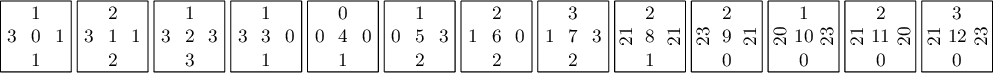

In [14]:
T1.tikz(font=r'\small', size=1.2, ncolumns=13)

## Computing $\mathcal{T}_2$

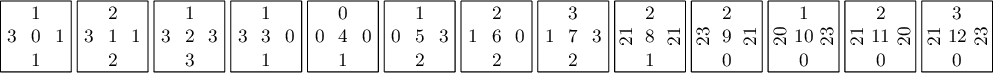

In [15]:
T1.tikz(font=r'\small', ncolumns=20, size=1.2)

In [16]:
%time T1.find_markers(i=2, radius=1, solver=solver) #385ms with dancing_links, 46s with Glucose, 2s with Gurobi

CPU times: user 416 ms, sys: 0 ns, total: 416 ms
Wall time: 413 ms


[[8, 9, 10, 11, 12]]

In [17]:
M1 = [8, 9, 10, 11, 12]
T2,omega1 = T1.find_substitution(M=M1, i=2, side='left', solver=solver)

In [18]:
show(omega1)

Substitution 2d: {0: [[0]], 1: [[1]], 2: [[2]], 3: [[3]], 4: [[4]], 5: [[5]], 6: [[6]], 7: [[7]], 8: [[8, 1]], 9: [[8, 5]], 10: [[8, 6]], 11: [[8, 7]], 12: [[9, 1]], 13: [[9, 5]], 14: [[9, 6]], 15: [[10, 0]], 16: [[10, 3]], 17: [[11, 5]], 18: [[11, 7]], 19: [[12, 2]]}

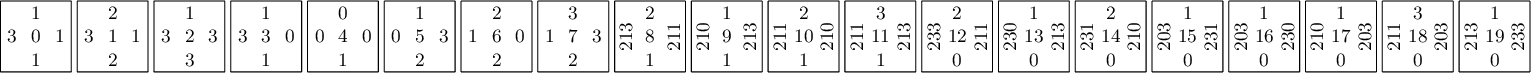

In [19]:
T2.tikz(font=r'\small', size=1.2, ncolumns=20)

## Computing $\mathcal{T}_3$

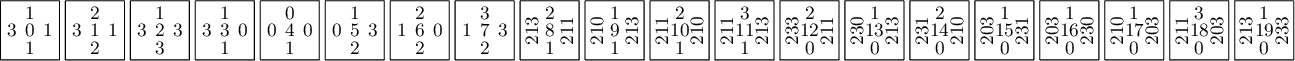

In [20]:
T2.tikz(font=r'\small', size=1, ncolumns=20)

In [21]:
%time T2.find_markers(i=2, radius=2, solver=solver) # 4s with dancing_links, 2min 23s with Glucose, 15s with Gurobi

CPU times: user 4.04 s, sys: 0 ns, total: 4.04 s
Wall time: 4.04 s


[[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

In [22]:
M2 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
T3,omega2 = T2.find_substitution(M=M2, i=2, side='left', radius=2, solver=solver)

In [23]:
show(omega2)

Substitution 2d: {0: [[2]], 1: [[3]], 2: [[4]], 3: [[5]], 4: [[8, 1]], 5: [[8, 5]], 6: [[8, 6]], 7: [[9, 0]], 8: [[9, 3]], 9: [[10, 5]], 10: [[10, 7]], 11: [[11, 2]], 12: [[12, 5]], 13: [[12, 6]], 14: [[13, 4]], 15: [[14, 5]], 16: [[15, 3]], 17: [[16, 3]], 18: [[16, 4]], 19: [[17, 3]], 20: [[18, 2]], 21: [[19, 0]], 22: [[19, 3]], 23: [[19, 4]]}

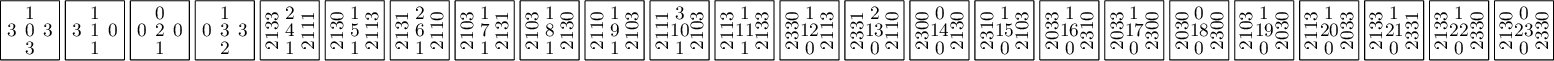

In [24]:
T3.tikz(font=r'\small', size=1, ncolumns=24)

## Computing $\mathcal{T}_4'$

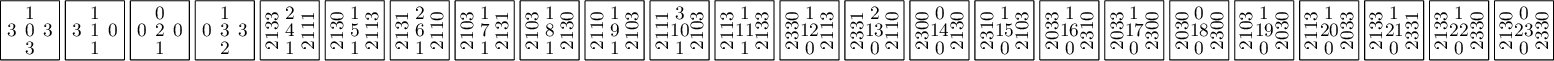

In [25]:
T3.tikz(font=r'\small', size=1, ncolumns=24)

In [26]:
%time T3.find_markers(i=2, radius=3, solver=solver) # 13s with dancing_links, 4min 55s with Glucose, 59s with Gurobi

CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 14.8 s


[[0, 1, 2, 3]]

In [27]:
M3 = [0, 1, 2, 3]
T4p,omega3p = T3.find_substitution(M=M3, i=2, side='right', radius=3, solver=solver)

In [28]:
show(omega3p)

Substitution 2d: {0: [[5]], 1: [[8]], 2: [[11]], 3: [[12]], 4: [[14]], 5: [[15]], 6: [[16]], 7: [[17]], 8: [[18]], 9: [[19]], 10: [[20]], 11: [[22]], 12: [[23]], 13: [[4, 3]], 14: [[5, 2]], 15: [[6, 3]], 16: [[7, 1]], 17: [[7, 2]], 18: [[8, 1]], 19: [[8, 2]], 20: [[9, 1]], 21: [[10, 0]], 22: [[11, 2]], 23: [[12, 2]], 24: [[13, 3]], 25: [[15, 2]], 26: [[16, 2]], 27: [[20, 2]], 28: [[21, 2]], 29: [[22, 2]]}

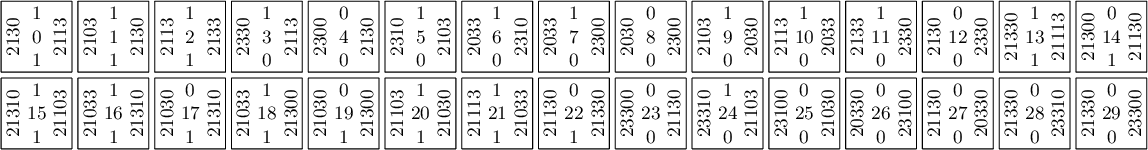

In [29]:
T4p.tikz(font=r'\small', size=1.2, ncolumns=15)

## Check that we can remove 2 tiles (tiles #24 and #28) from $\mathcal{T}_4'$

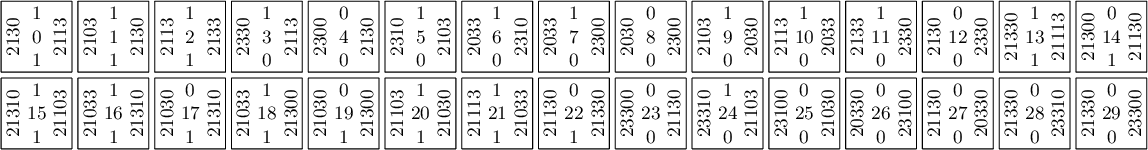

In [30]:
T4p.tikz(font=r'\small', size=1.2, ncolumns=15)

We check that tiles #24 and #28 can be removed from T4p. Since tile #28 is always to the left of #24, it suffices to check that the tile #24 does not admit a large enough surrounding (here of width 71 and heigth 9).

Gurobi or Glucose can solve this in a reasonable amount of time (<6s):

In [31]:
%%time
assert T4p[24] == ('21103', '1', '23310', '0')
S = T4p.solver(width=71, height=9, preassigned_tiles={(35,4):24})
print(S.has_solution(solver='glucose'))          # 6s with Gurobi, 4s with Glucose

False
CPU times: user 2.48 s, sys: 60 ms, total: 2.54 s
Wall time: 4.43 s


## Computing $\mathcal{T}_4$

In [32]:
forbidden = ('21103', '1', '23310', '0'), ('23310', '0', '21330', '0')
id_tiles = [(i,t) for (i,t) in enumerate(T4p) if t not in forbidden]
indices,tiles = zip(*id_tiles)
d = dict(enumerate(indices))
iota = Substitution2d.from_permutation(d)
T4 = WangTileSet(tiles)

In [33]:
omega3 = omega3p * iota
show(omega3)

Substitution 2d: {0: [[5]], 1: [[8]], 2: [[11]], 3: [[12]], 4: [[14]], 5: [[15]], 6: [[16]], 7: [[17]], 8: [[18]], 9: [[19]], 10: [[20]], 11: [[22]], 12: [[23]], 13: [[4, 3]], 14: [[5, 2]], 15: [[6, 3]], 16: [[7, 1]], 17: [[7, 2]], 18: [[8, 1]], 19: [[8, 2]], 20: [[9, 1]], 21: [[10, 0]], 22: [[11, 2]], 23: [[12, 2]], 24: [[15, 2]], 25: [[16, 2]], 26: [[20, 2]], 27: [[22, 2]]}

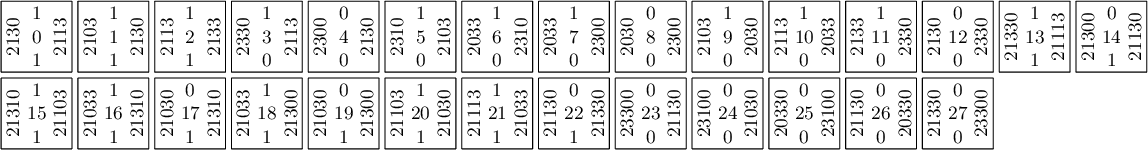

In [34]:
T4.tikz(font=r'\small', size=1.2, ncolumns=15)

## The morphism $\omega_0\omega_1\omega_2\omega_3:\Omega_{4}\to\Omega_{0}$

In [35]:
omega0to4 = omega0*omega1*omega2*omega3
show(omega0to4)

Substitution 2d: {0: [[0, 9, 3, 7]], 1: [[0, 9, 7, 5]], 2: [[0, 9, 10, 4]], 3: [[1, 3, 3, 7]], 4: [[1, 3, 7, 6]], 5: [[1, 3, 8, 7]], 6: [[1, 7, 2, 5]], 7: [[1, 7, 5, 5]], 8: [[1, 7, 5, 6]], 9: [[1, 8, 7, 5]], 10: [[1, 8, 10, 4]], 11: [[1, 10, 4, 5]], 12: [[1, 10, 4, 6]], 13: [[0, 9, 3, 3, 7]], 14: [[0, 9, 3, 7, 6]], 15: [[0, 9, 3, 8, 7]], 16: [[0, 9, 7, 2, 5]], 17: [[0, 9, 7, 2, 6]], 18: [[0, 9, 7, 5, 5]], 19: [[0, 9, 7, 5, 6]], 20: [[0, 9, 8, 7, 5]], 21: [[0, 9, 8, 10, 4]], 22: [[0, 9, 10, 4, 6]], 23: [[1, 3, 3, 7, 6]], 24: [[1, 3, 8, 7, 6]], 25: [[1, 7, 2, 5, 6]], 26: [[1, 8, 10, 4, 6]], 27: [[1, 10, 4, 5, 6]]}

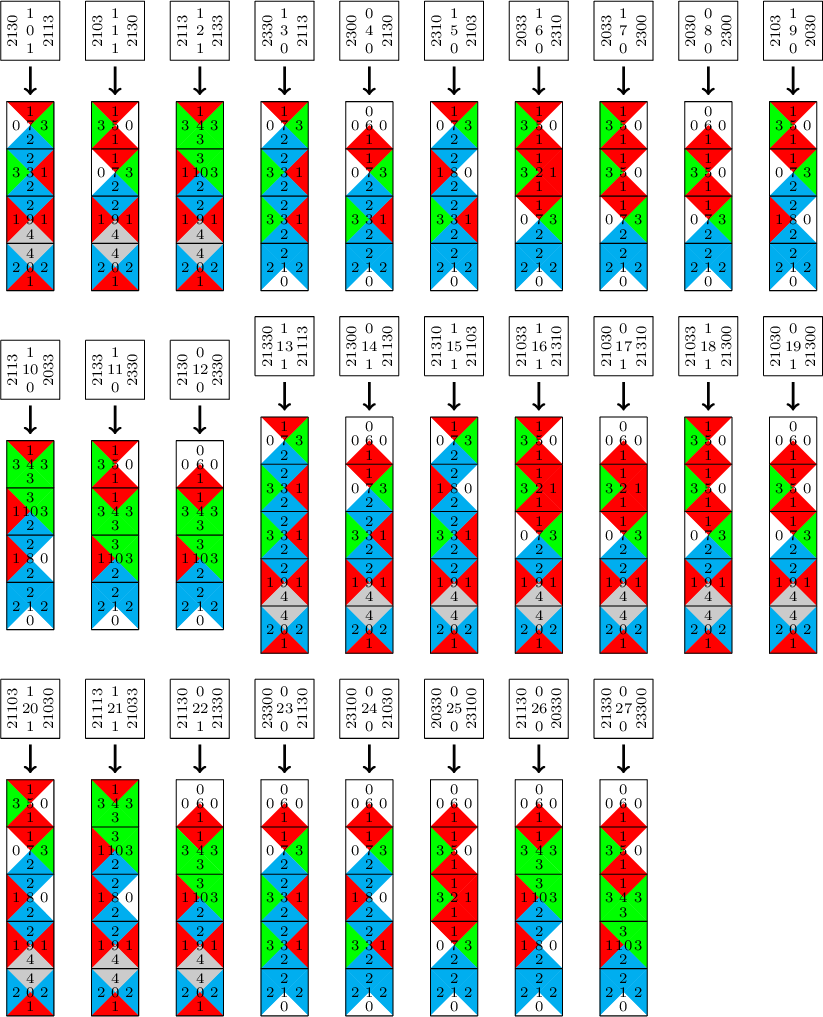

In [36]:
omega0to4.wang_tikz(T4, T0, font=r'\scriptsize', scale=.8, codomain_color=color, ncolumns=10, direction='down', extra_space=1.5)

## Trying to compute $\T_5$ ...

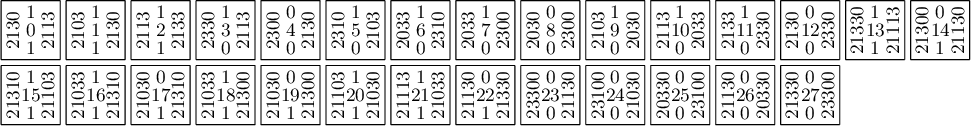

In [37]:
T4.tikz(font=r'\small', size=1, ncolumns=15)

In [38]:
%time T4.find_markers(i=1, radius=1, solver=solver)

CPU times: user 4.12 s, sys: 0 ns, total: 4.12 s
Wall time: 4.12 s


[]

In [39]:
%time T4.find_markers(i=2, radius=1, solver=solver)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 126 µs


[]

We have a **problem**: the Wang tile set $\T_4$ has markers neither in the direction $e_1$ nor $e_2$

So increasing the surrounding `radius` will not help here.

Even worse, we have **two** problems...



## Defining $\mathcal{T}_5$

The **first** problem is the presence of horizontal fracture lines which we can break by adding decorations on the horizontal edges of few tiles. We have to do it in a way that we forbid sliding along fracture lines and without destroying the overall structure of Wang tilings in $\Omega_4$.

We create the tile set $\mathcal{T}_5$ by adding decorations on $\mathcal{T}_4$.

For few tiles, the horizontal color 0 is replaced by color 6.

For few tiles, the horizontal color 1 is replaced by color 5.

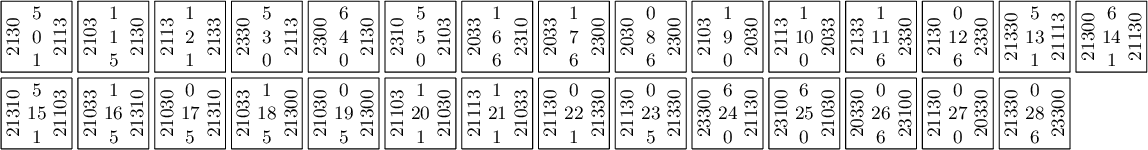

In [40]:
tiles5 = [('2113', '5', '2130', '1'),
 ('2130', '1', '2103', '5'),
 ('2133', '1', '2113', '1'),
 ('2113', '5', '2330', '0'),
 ('2130', '6', '2300', '0'),
 ('2103', '5', '2310', '0'),
 ('2310', '1', '2033', '6'),
 ('2300', '1', '2033', '6'),
 ('2300', '0', '2030', '6'),
 ('2030', '1', '2103', '0'),
 ('2033', '1', '2113', '0'),
 ('2330', '1', '2133', '6'),
 ('2330', '0', '2130', '6'),
 ('21113', '5', '21330', '1'),
 ('21130', '6', '21300', '1'),
 ('21103', '5', '21310', '1'),
 ('21310', '1', '21033', '5'),
 ('21310', '0', '21030', '5'),
 ('21300', '1', '21033', '5'),
 ('21300', '0', '21030', '5'),
 ('21030', '1', '21103', '1'),
 ('21033', '1', '21113', '1'),
 ('21330', '0', '21130', '1'),
 ('21330', '0', '21130', '5'),
 ('21130', '6', '23300', '0'),
 ('21030', '6', '23100', '0'),
 ('23100', '0', '20330', '6'),
 ('20330', '0', '21130', '0'),
 ('23300', '0', '21330', '6')]
T5 = WangTileSet(tiles5)
T5.tikz(font=r'\small', size=1.2, ncolumns=15)

## The morphism $\pi:\mathcal{T}_5\to\mathcal{T}_4$

The morphism $\pi$ erases the decorations on tiles of $\mathcal{T}_5$.

It projects the horizontal color 6 back to color 0, and the horizontal color 5 back to color 1.

On tiles, the map $\pi:\mathcal{T}_5\to\mathcal{T}_4$ is not injective as it maps two tiles (#22 and #23) onto the same (#22).

In [41]:
def project_56(t, p56='10'):
    L = []
    d = dict(zip('56', p56))
    for w in t:
        for a in '56':
            w = w.replace(a, d[a])
        L.append(w)
    return tuple(L)

In [42]:
T4_tiles_list = T4.tiles()
d = {}
for i,t in enumerate(T5):
    pt = project_56(t, p56='10')
    j = T4_tiles_list.index(pt)
    d[i] = j
omega4_pi = Substitution2d.from_permutation(d)
show(omega4_pi)

Substitution 2d: {0: [[0]], 1: [[1]], 2: [[2]], 3: [[3]], 4: [[4]], 5: [[5]], 6: [[6]], 7: [[7]], 8: [[8]], 9: [[9]], 10: [[10]], 11: [[11]], 12: [[12]], 13: [[13]], 14: [[14]], 15: [[15]], 16: [[16]], 17: [[17]], 18: [[18]], 19: [[19]], 20: [[20]], 21: [[21]], 22: [[22]], 23: [[22]], 24: [[23]], 25: [[24]], 26: [[25]], 27: [[26]], 28: [[27]]}

But surprise, on tilings, the map $\pi:\Omega_5\to\Omega_4$ defines a $2$-dimensional morphism which is an embedding, i.e., injective.

## Trying to compute $\T_6$ from $\T_5$ ...

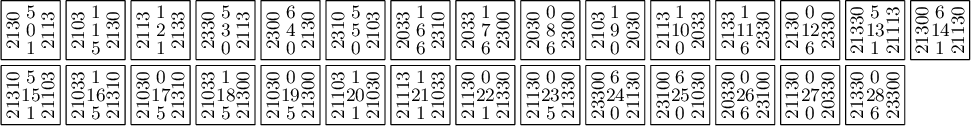

In [43]:
T5.tikz(font=r'\small', size=1, ncolumns=15)

In [44]:
%time T5.find_markers(i=1, radius=1, solver=solver)

CPU times: user 4.74 s, sys: 4 ms, total: 4.74 s
Wall time: 4.74 s


[]

In [45]:
%time T5.find_markers(i=2, radius=1, solver=solver)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 70.6 µs


[]

We still have a problem: the Wang tile set $\T_5$ has markers neither in the direction $e_1$ nor $e_2$

So increasing the surrounding `radius` will not help here.

## Tilings in $\Omega_5$

Let's look at tilings in $\Omega_5$.

In [46]:
tiling = T5.solver(30,10).solve(solver='glucose')

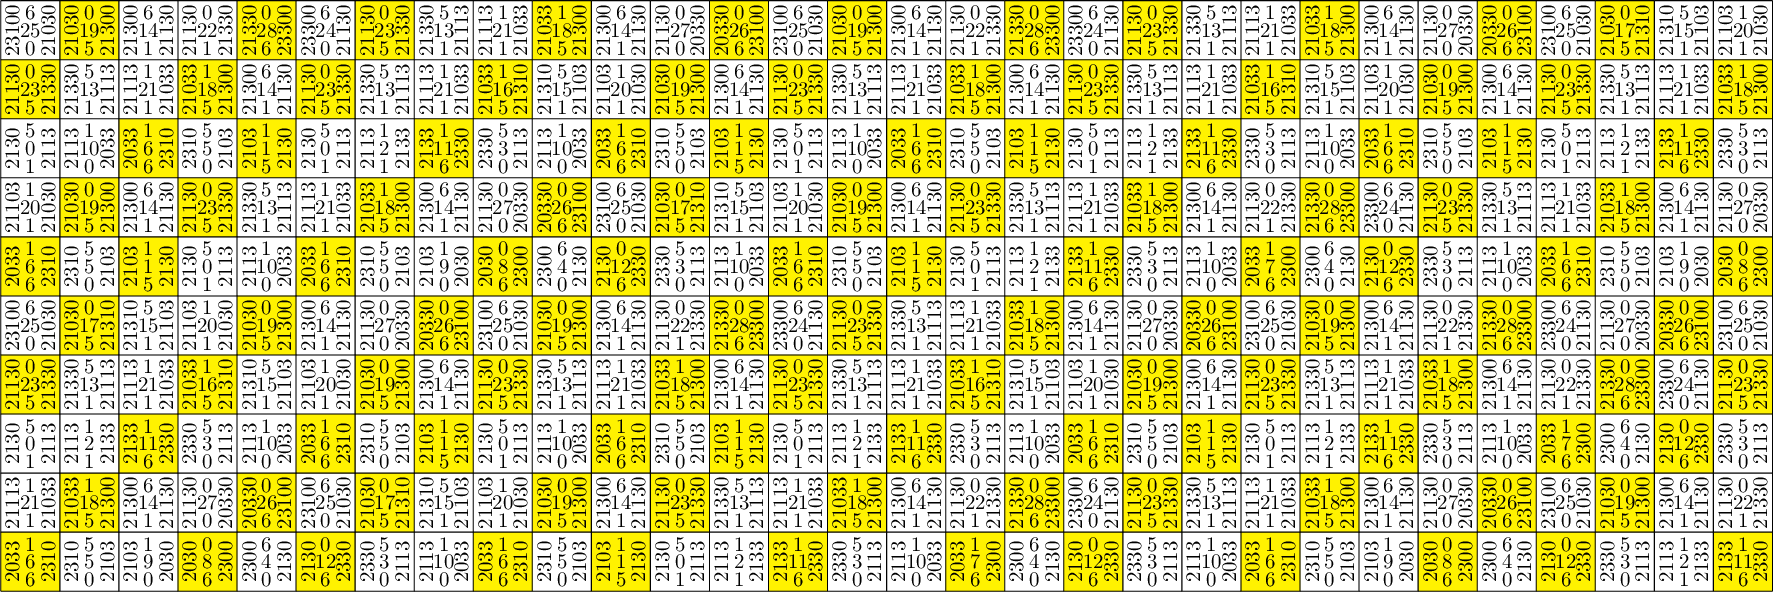

In [47]:
P = tiling.tile_positions([1, 6, 7, 8, 11, 12, 16, 17, 18, 19, 23, 26, 28])
s = '\n'.join([r'\fill[yellow] {} rectangle {};'.format((a,b), (a+1,b+1)) for (a,b) in P])
tiling.tikz(extra_before=s)

## Computing $\mathcal{T}_6$ and the shear topological conjugacy $\eta:\Omega_6\to\Omega_5$

The **second** problem is that $\T_5$ does not have markers, it has diagonal markers, i.e., markers appears on lines of slope 1.

To fix this, instead of introducing the notion of *diagonal markers*, we choose to transform the Wang tile set in a way that it shears the tiling by the matrix $\left(\begin{smallmatrix} 1 & -1 \\ 0 & 1\end{smallmatrix}\right)$ so that markers become vertical.

In [48]:
%tikz -i shear.tikz -p amssymb --no-wrap

This transformation on tiles yields a homeomorphism $\eta:\Omega_6\to\Omega_5$ which commutes the normal shift on $\Omega_5$ into the sheared shift on $\Omega_6$.

In [49]:
%time T6,omega5_sheer = T5.shear(radius=2, solver=solver) # 6s with dancing_links, 3min 12s with Glucose, 22s with Gurobi

CPU times: user 6.38 s, sys: 0 ns, total: 6.38 s
Wall time: 6.38 s


In [50]:
show(omega5_sheer)

Substitution 2d: {0: [[0]], 1: [[1]], 2: [[2]], 3: [[3]], 4: [[4]], 5: [[5]], 6: [[6]], 7: [[7]], 8: [[8]], 9: [[9]], 10: [[10]], 11: [[11]], 12: [[12]], 13: [[13]], 14: [[14]], 15: [[15]], 16: [[16]], 17: [[17]], 18: [[18]], 19: [[19]], 20: [[20]], 21: [[21]], 22: [[22]], 23: [[23]], 24: [[24]], 25: [[25]], 26: [[26]], 27: [[27]], 28: [[28]]}

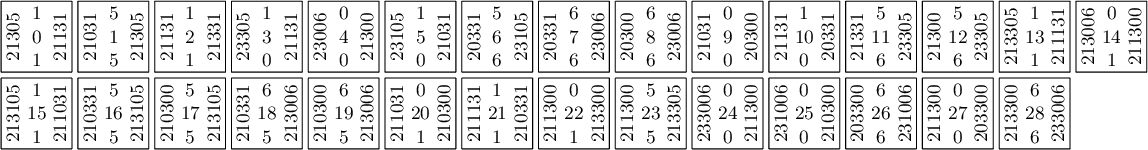

In [51]:
T6.tikz(font=r'\small', size=1.2, ncolumns=15)

## Computing $\mathcal{T}_7$

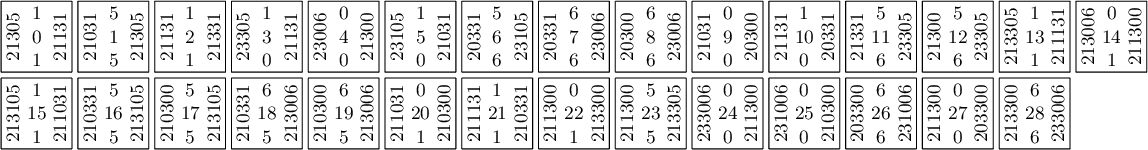

In [52]:
T6.tikz(font=r'\small', size=1.2, ncolumns=15)

In [53]:
%time T6.find_markers(i=1, radius=1, solver=solver) # 5s with dancing_links, 4min 25s with Glucose, 17s with Gurobi

CPU times: user 4.79 s, sys: 4 ms, total: 4.8 s
Wall time: 4.8 s


[[0, 3, 4, 5, 13, 14, 15, 24, 25],
 [1, 6, 7, 8, 11, 12, 16, 17, 18, 19, 23, 26, 28],
 [2, 9, 10, 20, 21, 22, 27]]

Youpi! The tile set $\T_6$ has 3 subsets of markers in the direction $e_1$. Thus, we may chose one, desubstitute and compute $\T_7$.

In [54]:
M6 = [1, 6, 7, 8, 11, 12, 16, 17, 18, 19, 23, 26, 28]
T7,omega6 = T6.find_substitution(M=M6, i=1, radius=1, side='left', solver=solver)

In [55]:
show(omega4_pi*omega5_sheer*omega6)

Substitution 2d: {0: [[2]], 1: [[9]], 2: [[10]], 3: [[20]], 4: [[21]], 5: [[22]], 6: [[26]], 7: [[1], [0]], 8: [[6], [5]], 9: [[7], [4]], 10: [[8], [4]], 11: [[11], [3]], 12: [[12], [3]], 13: [[16], [15]], 14: [[17], [15]], 15: [[18], [14]], 16: [[19], [14]], 17: [[22], [13]], 18: [[25], [24]], 19: [[27], [23]]}

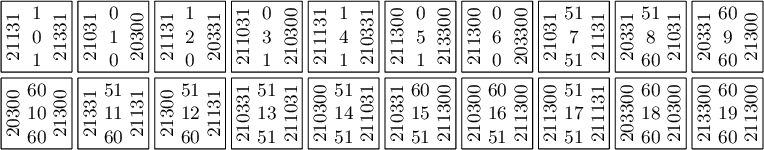

In [56]:
T7.tikz(font=r'\small', size=1.2)

## Computing $\mathcal{T}_8$

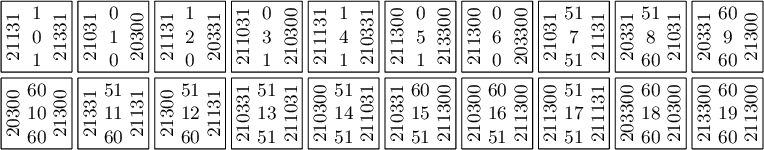

In [57]:
T7.tikz(font=r'\small', size=1.2)

In [58]:
%time T7.find_markers(i=1, radius=1, solver=solver) # 2s with dancing_links, 2min with Glucose, 6s with Gurobi

CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.53 s


[[0, 1, 2, 3, 4, 5, 6]]

In [59]:
M7 = [0, 1, 2, 3, 4, 5, 6]
T8,omega7 = T7.find_substitution(M=M7, i=1, radius=1, solver=solver)

In [60]:
show(omega7)

Substitution 2d: {0: [[8]], 1: [[9]], 2: [[10]], 3: [[15]], 4: [[16]], 5: [[18]], 6: [[19]], 7: [[7], [0]], 8: [[7], [2]], 9: [[8], [1]], 10: [[11], [2]], 11: [[12], [2]], 12: [[13], [3]], 13: [[14], [3]], 14: [[15], [5]], 15: [[15], [6]], 16: [[16], [5]], 17: [[16], [6]], 18: [[17], [4]], 19: [[19], [6]]}

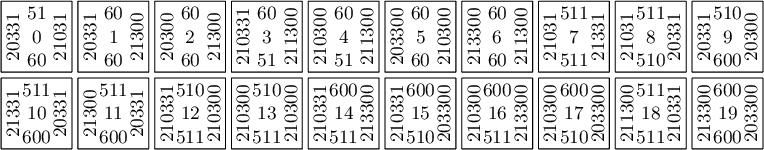

In [61]:
T8.tikz(font=r'\small', size=1.2)

## Computing $\mathcal{T}_9$

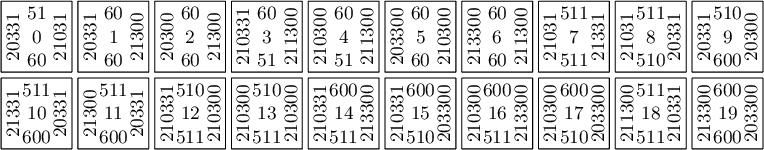

In [62]:
T8.tikz(font=r'\small', size=1.2)

In [63]:
%time T8.find_markers(i=2, radius=2, solver=solver) # 4s with dancing_links, 2min 24s with Glucose, 15s with Gurobi

CPU times: user 3.98 s, sys: 0 ns, total: 3.98 s
Wall time: 3.97 s


[[0, 1, 2, 7, 8, 9, 10, 11]]

In [64]:
M8 = [0, 1, 2, 7, 8, 9, 10, 11]
T9,omega8 = T8.find_substitution(M=M8, i=2, radius=2, solver=solver)

In [65]:
show(omega8)

Substitution 2d: {0: [[3]], 1: [[4]], 2: [[5]], 3: [[6]], 4: [[12]], 5: [[13]], 6: [[14]], 7: [[15]], 8: [[18]], 9: [[4, 0]], 10: [[5, 0]], 11: [[5, 1]], 12: [[5, 2]], 13: [[6, 0]], 14: [[13, 8]], 15: [[14, 10]], 16: [[15, 10]], 17: [[16, 11]], 18: [[17, 9]], 19: [[17, 11]], 20: [[18, 7]], 21: [[19, 9]]}

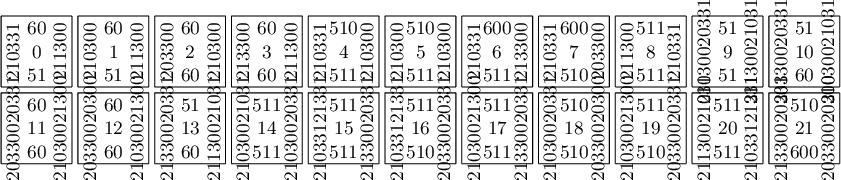

In [66]:
T9.tikz(font=r'\small', size=1.2, ncolumns=11)

Since the colors of tiles in $\T_9$ are too long words, it is preferable to look at the Wang tile set $\T_9$ as a table:

In [67]:
T9.table()

Id   Right         Top   Left          Bottom
+----+-------------+-----+-------------+--------+
  0    211300        60    210331        51
  1    211300        60    210300        51
  2    210300        60    203300        60
  3    211300        60    213300        60
  4    210300        510   210331        511
  5    210300        510   210300        511
  6    213300        600   210331        511
  7    203300        600   210331        510
  8    210331        511   211300        511
  9    21130021031   51    21030020331   51
  10   21030021031   51    20330020331   60
  11   21030021300   60    20330020331   60
  12   21030021300   60    20330020300   60
  13   21130021031   51    21330020331   60
  14   21030020331   511   21030021031   511
  15   21330020331   511   21033121331   511
  16   20330020331   511   21033121331   510
  17   21330020331   511   21030021300   511
  18   20330020300   510   21030020331   510
  19   20330020331   511   21030021300   510
  20   21033121331   511   21130021031   511
  21   20330020300   510   21330020331   600

## Computing $\mathcal{T}_{10}$

In [68]:
%time T9.find_markers(i=1, radius=1, solver=solver) # 2s with dancing_links, 2min 30s with Glucose, 8s with Gurobi

CPU times: user 2.03 s, sys: 4 ms, total: 2.04 s
Wall time: 2.04 s


[[0, 1, 2, 3, 9, 10, 11, 12, 13],
 [4, 6, 7, 15, 16, 18, 21],
 [5, 8, 14, 17, 19, 20]]

In [69]:
M9 = [0, 1, 2, 3, 9, 10, 11, 12, 13]
T10,omega9 = T9.find_substitution(M=M9, i=1, radius=1, solver=solver)

In [70]:
show(omega9)

Substitution 2d: {0: [[8]], 1: [[14]], 2: [[17]], 3: [[20]], 4: [[4], [1]], 5: [[5], [1]], 6: [[6], [3]], 7: [[7], [2]], 8: [[8], [0]], 9: [[14], [9]], 10: [[15], [13]], 11: [[16], [10]], 12: [[16], [11]], 13: [[17], [13]], 14: [[18], [12]], 15: [[19], [10]], 16: [[19], [11]], 17: [[21], [12]]}

In [71]:
T10.table()

Id   Right         Top     Left          Bottom
+----+-------------+-------+-------------+--------+
  0    210331        511     211300        511
  1    21030020331   511     21030021031   511
  2    21330020331   511     21030021300   511
  3    21033121331   511     21130021031   511
  4    211300        51060   210331        51151
  5    211300        51060   210300        51151
  6    211300        60060   210331        51160
  7    210300        60060   210331        51060
  8    211300        51160   211300        51151
  9    21130021031   51151   21030021031   51151
  10   21130021031   51151   21033121331   51160
  11   21030021031   51151   21033121331   51060
  12   21030021300   51160   21033121331   51060
  13   21130021031   51151   21030021300   51160
  14   21030021300   51060   21030020331   51060
  15   21030021031   51151   21030021300   51060
  16   21030021300   51160   21030021300   51060
  17   21030021300   51060   21330020331   60060

## Computing $\mathcal{T}_{11}$

In [72]:
%time T10.find_markers(i=2, radius=2, solver=solver) # 3s with dancing_links, 1min 52s with Glucose, 11s with Gurobi

CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.92 s


[[0, 4, 5, 6, 7, 8]]

In [73]:
M10 = [0, 4, 5, 6, 7, 8]
T11,omega10 = T10.find_substitution(M=M10, i=2, radius=2, solver=solver)

In [74]:
show(omega10)

Substitution 2d: {0: [[1]], 1: [[2]], 2: [[3]], 3: [[12]], 4: [[13]], 5: [[14]], 6: [[15]], 7: [[16]], 8: [[17]], 9: [[1, 0]], 10: [[2, 0]], 11: [[3, 0]], 12: [[9, 8]], 13: [[10, 4]], 14: [[11, 4]], 15: [[12, 6]], 16: [[13, 5]], 17: [[13, 8]], 18: [[14, 7]], 19: [[15, 5]], 20: [[17, 7]]}

In [75]:
T11.table()

Id   Right               Top     Left                Bottom
+----+-------------------+-------+-------------------+--------+
  0    21030020331         511     21030021031         511
  1    21330020331         511     21030021300         511
  2    21033121331         511     21130021031         511
  3    21030021300         51160   21033121331         51060
  4    21130021031         51151   21030021300         51160
  5    21030021300         51060   21030020331         51060
  6    21030021031         51151   21030021300         51060
  7    21030021300         51160   21030021300         51060
  8    21030021300         51060   21330020331         60060
  9    21030020331210331   511     21030021031211300   511
  10   21330020331210331   511     21030021300211300   511
  11   21033121331210331   511     21130021031211300   511
  12   21130021031211300   51160   21030021031211300   51151
  13   21130021031211300   51060   21033121331210331   51160
  14   21030021031211300   51060   21033121331210331   51060
  15   21030021300211300   60060   21033121331210331   51060
  16   21130021031211300   51060   21030021300210300   51160
  17   21130021031211300   51160   21030021300211300   51160
  18   21030021300210300   60060   21030020331210331   51060
  19   21030021031211300   51060   21030021300210300   51060
  20   21030021300210300   60060   21330020331210331   60060

## Computing $\mathcal{T}_{12}$

In [76]:
%time T11.find_markers(i=1, radius=1, solver=solver) # 2s with dancing_links, 2min 15s with Glucose, 7s with Gurobi

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


[[0, 1, 2, 9, 10, 11],
 [3, 5, 8, 13, 14, 15, 18, 20],
 [4, 6, 7, 12, 16, 17, 19]]

In [77]:
M11 = [0, 1, 2, 9, 10, 11]
T12,omega11 = T11.find_substitution(M=M11, i=1, radius=1, solver=solver)

In [78]:
show(omega11)

Substitution 2d: {0: [[5]], 1: [[8]], 2: [[14]], 3: [[15]], 4: [[18]], 5: [[20]], 6: [[3], [1]], 7: [[4], [2]], 8: [[5], [1]], 9: [[6], [0]], 10: [[7], [1]], 11: [[8], [1]], 12: [[12], [11]], 13: [[13], [11]], 14: [[14], [9]], 15: [[15], [10]], 16: [[16], [11]], 17: [[17], [11]], 18: [[19], [9]]}

In [79]:
T12.table()

Id   Right               Top        Left                Bottom
+----+-------------------+----------+-------------------+----------+
  0    21030021300         51060      21030020331         51060
  1    21030021300         51060      21330020331         60060
  2    21030021031211300   51060      21033121331210331   51060
  3    21030021300211300   60060      21033121331210331   51060
  4    21030021300210300   60060      21030020331210331   51060
  5    21030021300210300   60060      21330020331210331   60060
  6    21330020331         51160511   21033121331         51060511
  7    21033121331         51151511   21030021300         51160511
  8    21330020331         51060511   21030020331         51060511
  9    21030020331         51151511   21030021300         51060511
  10   21330020331         51160511   21030021300         51060511
  11   21330020331         51060511   21330020331         60060511
  12   21033121331210331   51160511   21030021031211300   51151511
  13   21033121331210331   51060511   21033121331210331   51160511
  14   21030020331210331   51060511   21033121331210331   51060511
  15   21330020331210331   60060511   21033121331210331   51060511
  16   21033121331210331   51060511   21030021300210300   51160511
  17   21033121331210331   51160511   21030021300211300   51160511
  18   21030020331210331   51060511   21030021300210300   51060511

## A self-similar aperiodic set $\mathcal{U}$ of 19 Wang tiles

S. Labbé, A self-similar aperiodic set of 19 Wang tiles, Geometriae Dedicata, (2018)  
[doi:10.1007/s10711-018-0384-8](https://doi.org/10.1007/s10711-018-0384-8).
Preprint: [arXiv:1802.03265](http://arxiv.org/abs/1802.03265)

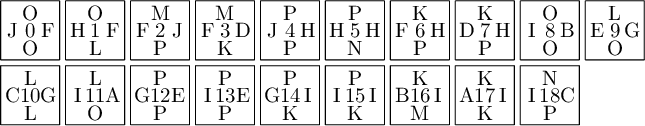

In [80]:
tilesU = ['FOJO','FOHL','JMFP','DMFK','HPJP','HPHN','HKFP','HKDP','BOIO','GLEO','GLCL',
'ALIO','EPGP','EPIP','IPGK','IPIK','IKBM','IKAK','CNIP',]
tilesU = [tuple(tile) for tile in tilesU]
U = WangTileSet(tilesU)
U.tikz(size=1)

The tile sets $\mathcal{U}$ and $\mathcal{T}_{12}$ are **equivalent**:

In [81]:
is_equiv,f,g,permUtoT12 = U.is_equivalent(T12, certificate=True)
is_equiv,f,g

(True,
 {'J': '21030020331',
  'F': '21030021300',
  'H': '21330020331',
  'D': '21033121331',
  'I': '21033121331210331',
  'B': '21030021031211300',
  'A': '21030021300211300',
  'E': '21030020331210331',
  'C': '21330020331210331',
  'G': '21030021300210300'},
 {'O': '51060',
  'L': '60060',
  'P': '51060511',
  'M': '51151511',
  'K': '51160511',
  'N': '60060511'})

In [82]:
show(permUtoT12)

Substitution 2d: {0: [[0]], 1: [[1]], 2: [[9]], 3: [[7]], 4: [[8]], 5: [[11]], 6: [[10]], 7: [[6]], 8: [[2]], 9: [[4]], 10: [[5]], 11: [[3]], 12: [[18]], 13: [[14]], 14: [[16]], 15: [[13]], 16: [[12]], 17: [[17]], 18: [[15]]}

## Computing $\mathcal{T}_{13}$

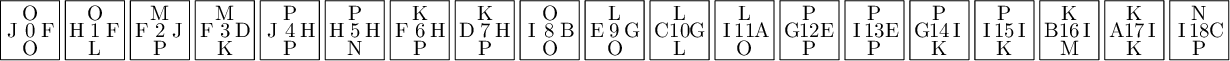

In [83]:
U.tikz(size=1, ncolumns=20)

In [84]:
%time U.find_markers(i=2, radius=2, solver=solver) # 3s with dancing_links, 13s with Gurobi

CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 3.51 s


[[0, 1, 2, 3, 4, 5, 6, 7]]

In [85]:
M12 = [0, 1, 2, 3, 4, 5, 6, 7]
T13,omega12 = U.find_substitution(M=M12, i=2, radius=2, solver=solver)

In [86]:
show(omega12)

Substitution 2d: {0: [[8]], 1: [[9]], 2: [[11]], 3: [[13]], 4: [[14]], 5: [[15]], 6: [[16]], 7: [[17]], 8: [[8, 0]], 9: [[9, 1]], 10: [[10, 1]], 11: [[11, 1]], 12: [[12, 6]], 13: [[13, 4]], 14: [[13, 7]], 15: [[14, 2]], 16: [[14, 6]], 17: [[15, 7]], 18: [[16, 3]], 19: [[17, 3]], 20: [[18, 5]]}

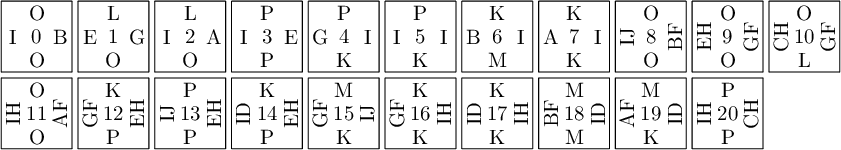

In [87]:
T13.tikz(size=1.2, ncolumns=11)

## Computing $\mathcal{T}_{14}$

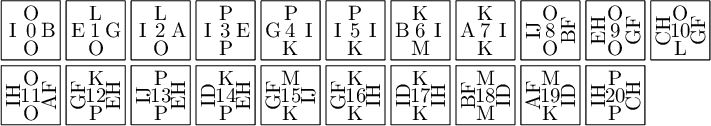

In [88]:
T13.tikz(size=1, ncolumns=11)

In [89]:
%time T13.find_markers(i=1, radius=1, solver=solver) # 2s with dancing_links, 7s with Gurobi

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 1.77 s


[[0, 1, 2, 8, 9, 10, 11],
 [3, 5, 13, 14, 17, 20],
 [4, 6, 7, 12, 15, 16, 18, 19]]

In [90]:
M13 = [0, 1, 2, 8, 9, 10, 11]
T14,omega13 = T13.find_substitution(M=M13, i=1, radius=1, solver=solver)

In [91]:
show(omega13)

Substitution 2d: {0: [[6]], 1: [[7]], 2: [[15]], 3: [[16]], 4: [[18]], 5: [[19]], 6: [[3], [1]], 7: [[4], [0]], 8: [[5], [0]], 9: [[5], [2]], 10: [[6], [0]], 11: [[7], [0]], 12: [[12], [9]], 13: [[13], [9]], 14: [[14], [9]], 15: [[15], [8]], 16: [[16], [11]], 17: [[17], [11]], 18: [[20], [10]]}

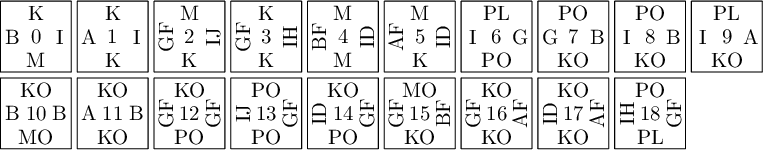

In [92]:
T14.tikz(size=1.2)

## The self-similarity $\omega_{\U}:\Omega_{\U}\to\Omega_{\U}$

In [93]:
is_equiv,f,g,permUtoW = U.is_equivalent(T14, certificate=True)
assert is_equiv
omegaUtoU = omega12 * omega13 * permUtoW

In [94]:
show(omegaUtoU)

Substitution 2d: {0: [[17]], 1: [[16]], 2: [[15], [11]], 3: [[13], [9]], 4: [[17], [8]], 5: [[16], [8]], 6: [[15], [8]], 7: [[14], [8]], 8: [[14, 6]], 9: [[17, 3]], 10: [[16, 3]], 11: [[14, 2]], 12: [[15, 7], [11, 1]], 13: [[14, 6], [11, 1]], 14: [[13, 7], [9, 1]], 15: [[12, 6], [9, 1]], 16: [[18, 5], [10, 1]], 17: [[13, 4], [9, 1]], 18: [[14, 2], [8, 0]]}

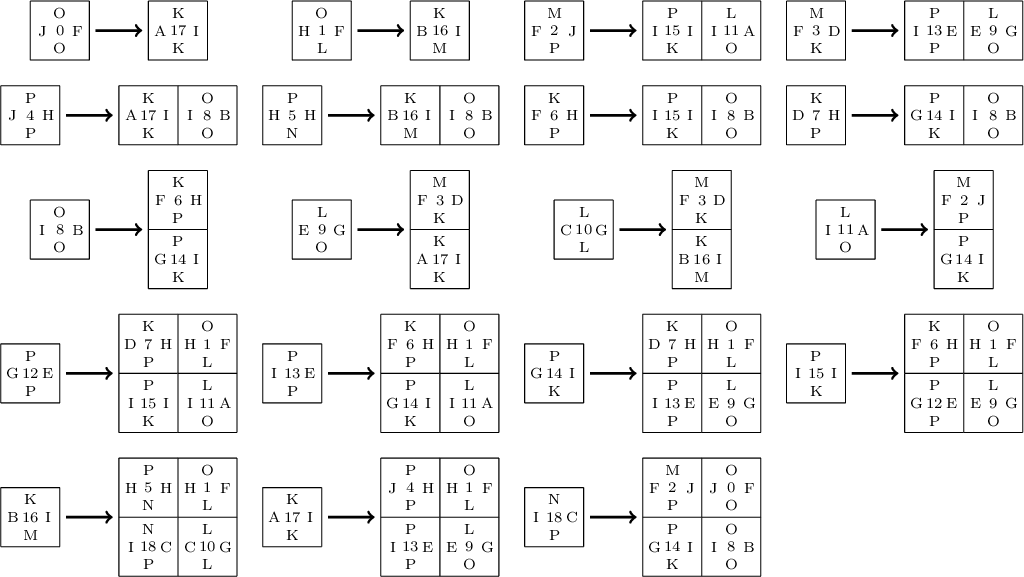

In [95]:
omegaUtoU.wang_tikz(U, U, font=r'\scriptsize', scale=1, codomain_color=color, ncolumns=4, 
            direction='right', extra_space=1.5)

In [96]:
M = matrix(2, [1,1,0,1])
omega5toU = omega5_sheer*omega6*omega7*omega8*omega9*omega10*omega11*permUtoT12
omega4toU = omega4_pi*omega5toU
omega5toUsheer = omega5toU.apply_matrix_transformation(M)
omega4toUsheer = omega4toU.apply_matrix_transformation(M)
omega3 = omega3p * iota
omega0to4 = omega0*omega1*omega2*omega3
omega0toU = omega0to4*omega4toUsheer

## The morphism $\eta\omega_6\omega_7\omega_8\omega_9\omega_{10}\omega_{11}\rho:\Omega_\U\to\Omega_{5}$

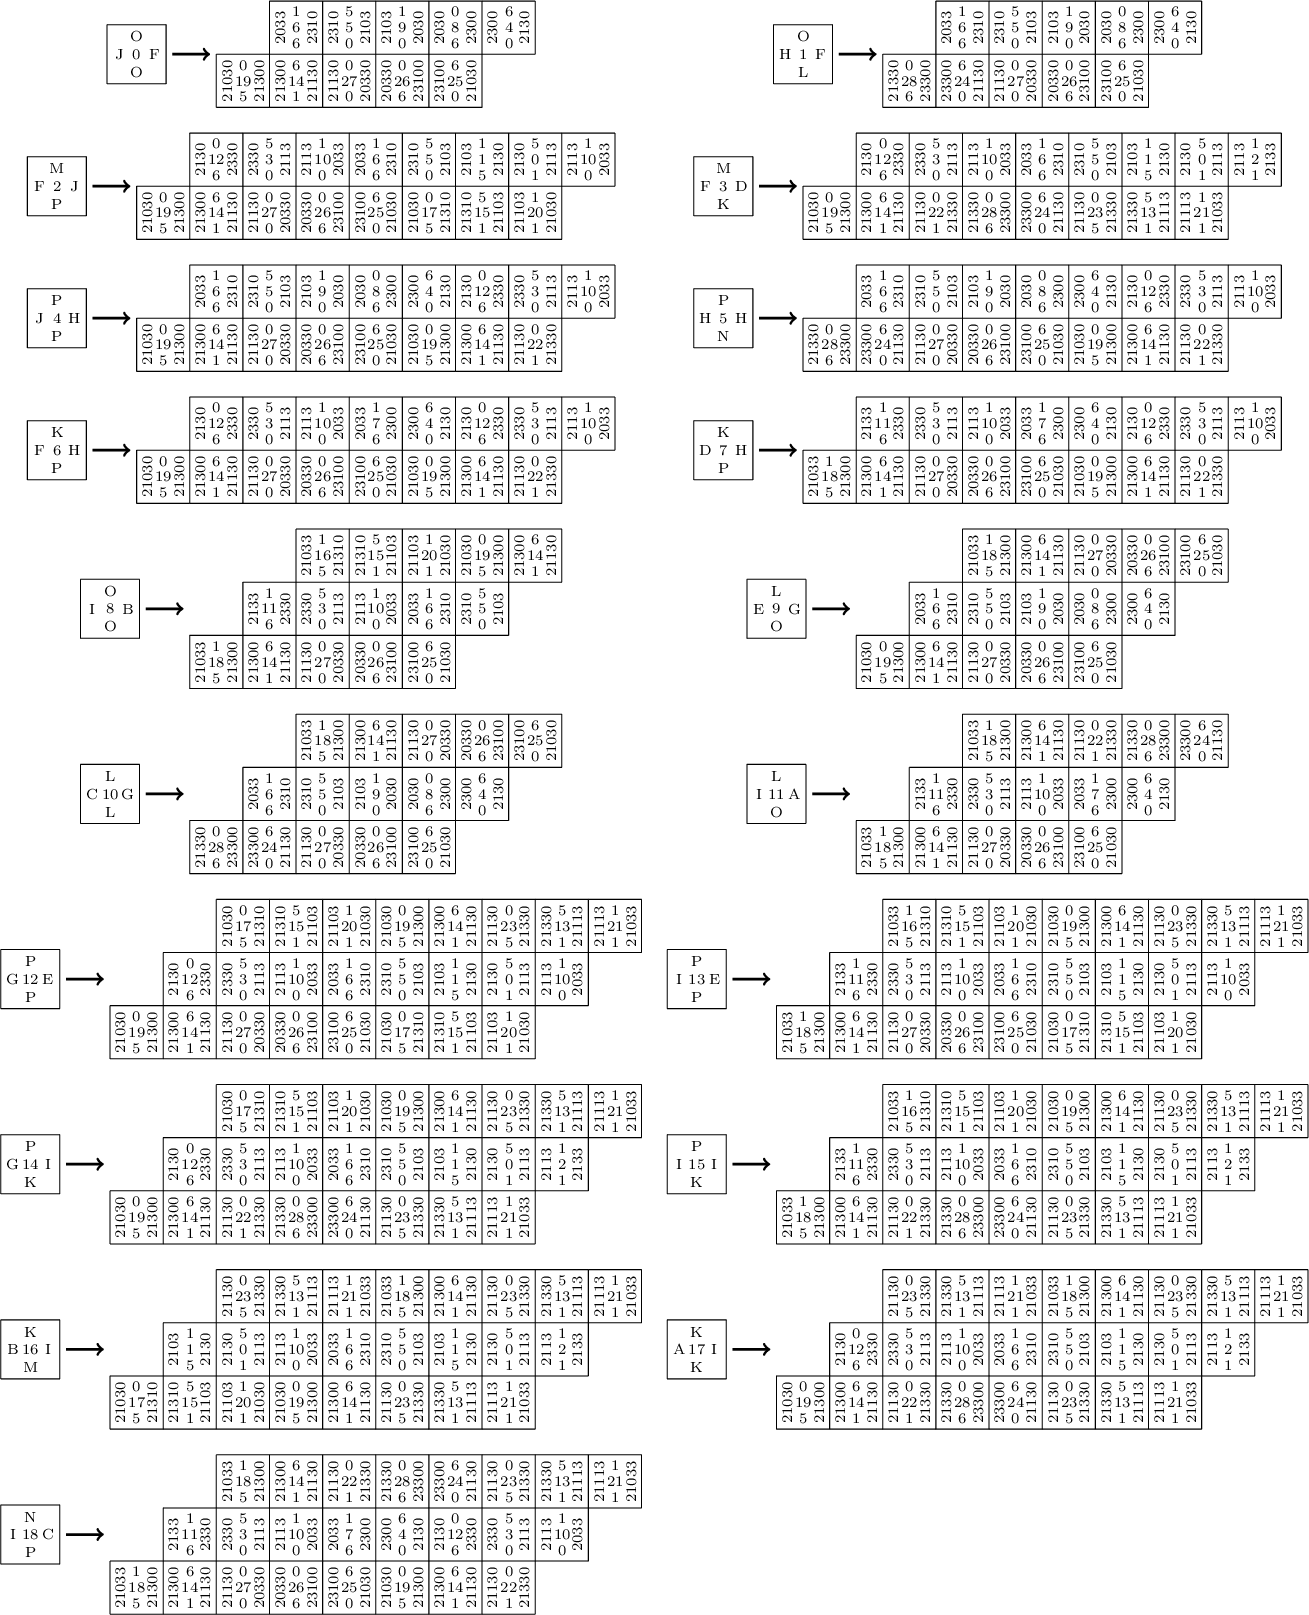

In [97]:
omega5toUsheer.wang_tikz(U, T5, font=r'\scriptsize', scale=.9, ncolumns=2, extra_space=1.5)

## The morphism $\pi\eta\omega_6\omega_7\omega_8\omega_9\omega_{10}\omega_{11}\rho:\Omega_\U\to\Omega_{4}$

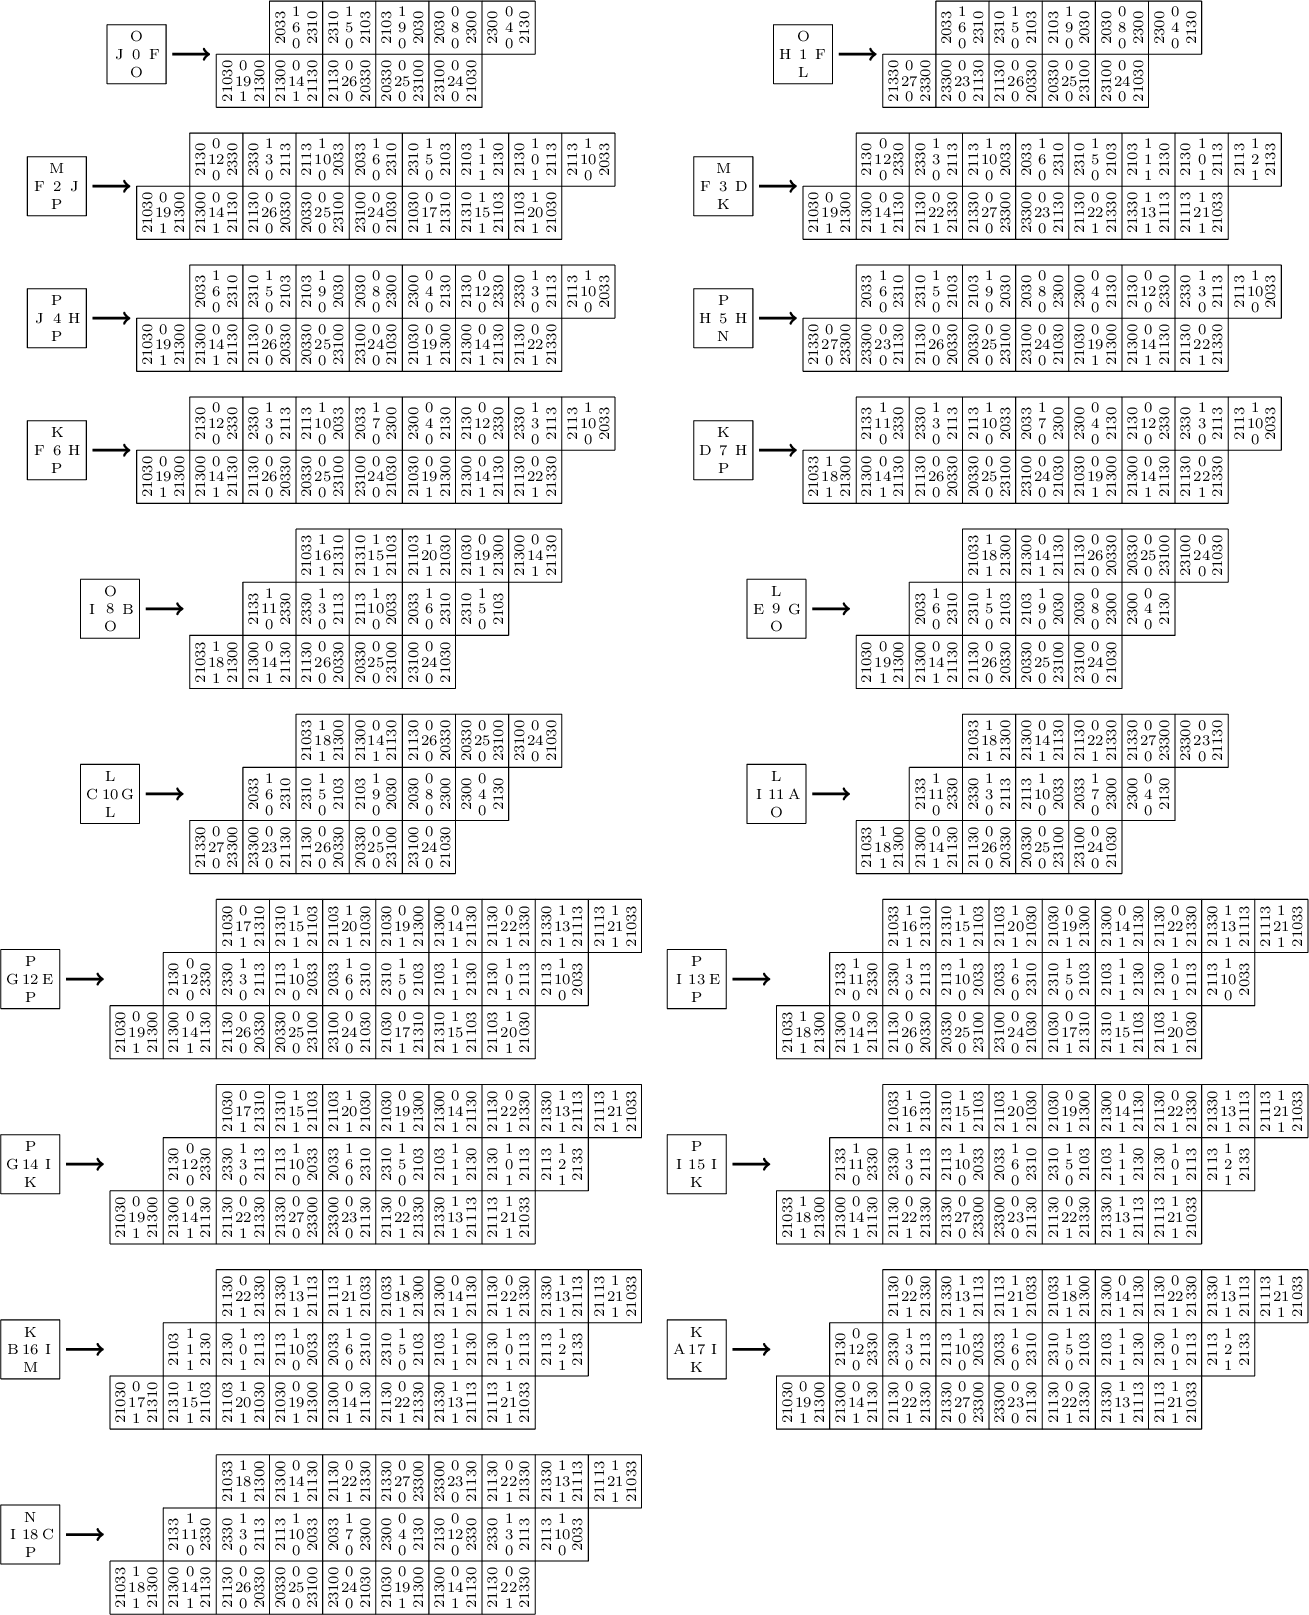

In [98]:
omega4toUsheer.wang_tikz(U, T4, font=r'\scriptsize', scale=.9, ncolumns=2, extra_space=1.5)

## The morphism $\omega_0\omega_1\omega_2\omega_3\pi\eta\omega_6\omega_7\omega_8\omega_9\omega_{10}\omega_{11}:\Omega_{12}\to\Omega_{0}$

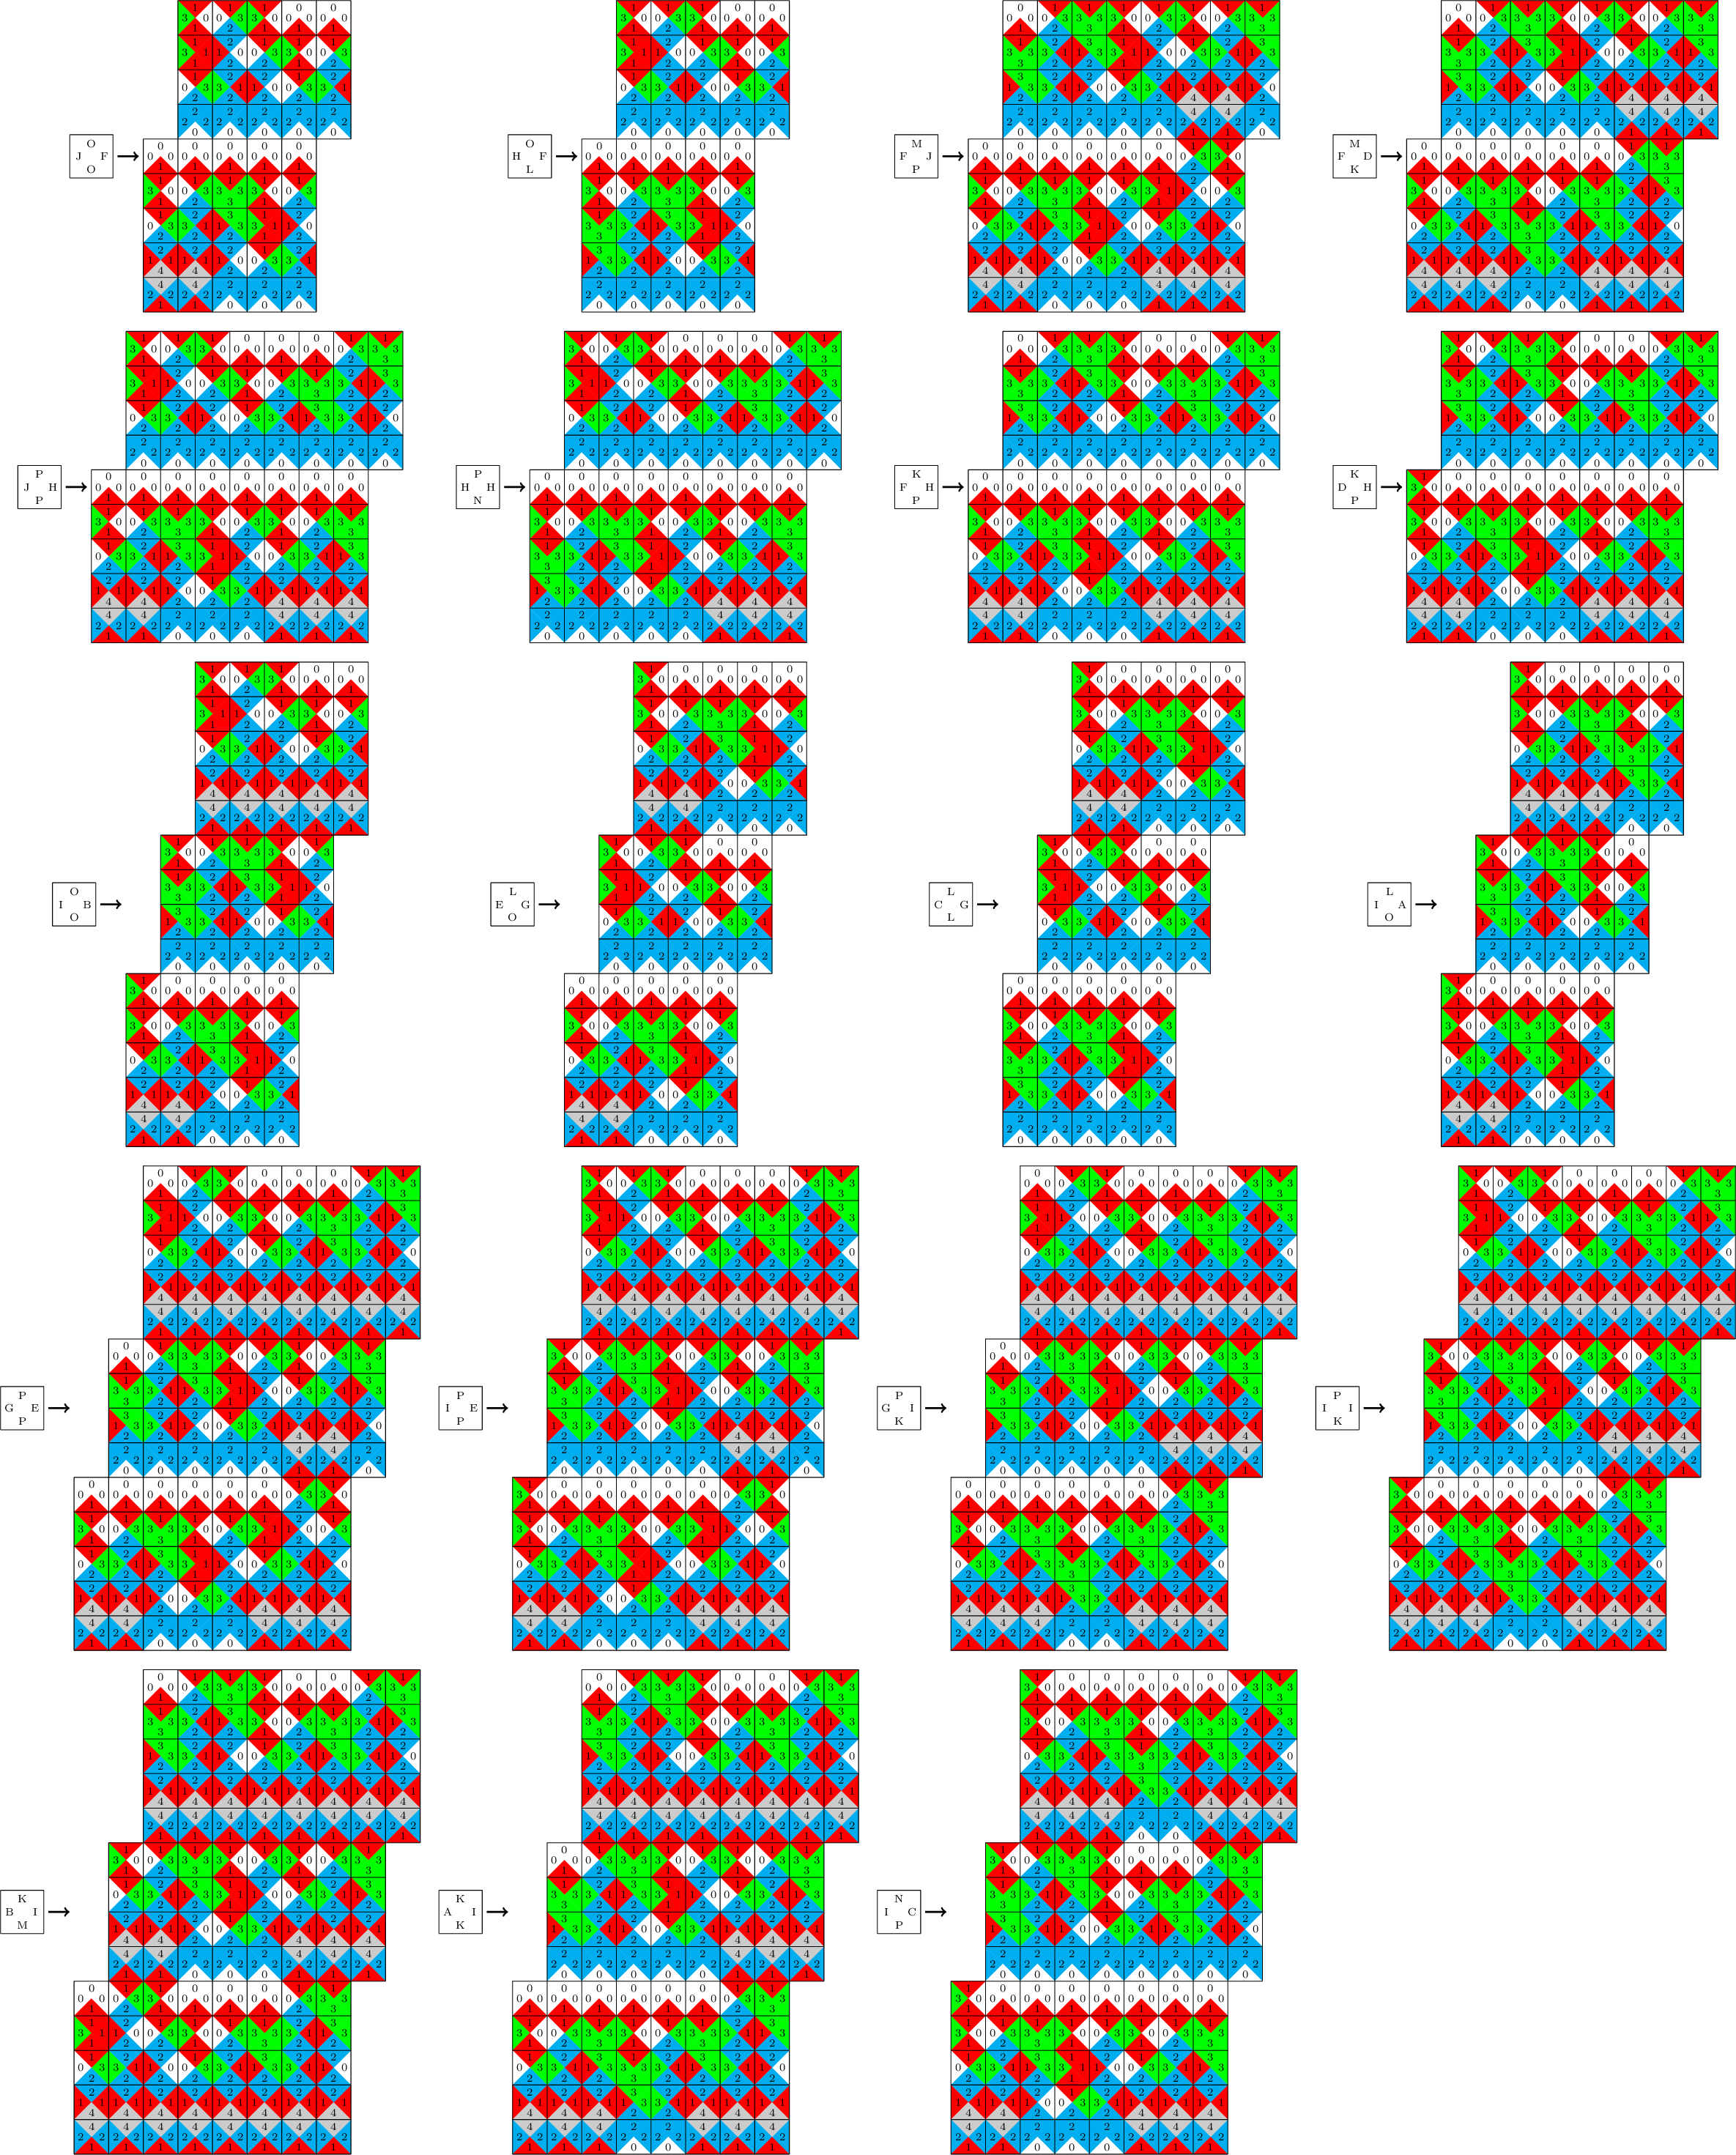

In [99]:
omega0toU.wang_tikz(U, T0, font=r'\scriptsize', scale=.8, codomain_color=color, id=None, 
                 ncolumns=4, direction='right', extra_space=1.5)

## Computing the eight fixed point of $\omega_{12}:\Omega_{12}\to\Omega_{12}$

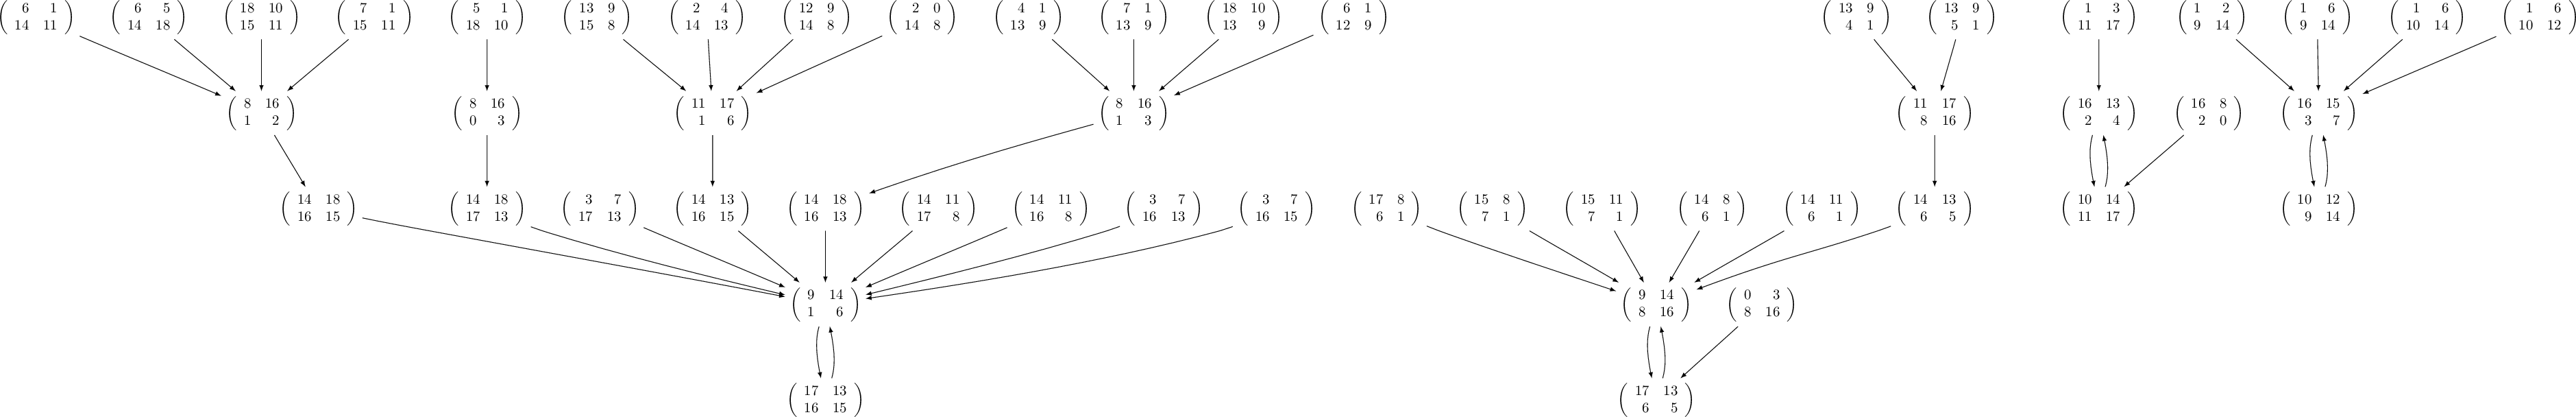

In [100]:
from slabbe import TikzPicture
G = omegaUtoU.prolongable_origins()
TikzPicture.from_graph(G, rankdir='down')

## Horizontal Rauzy graph for the tiles $\mathcal{T}_{12}$

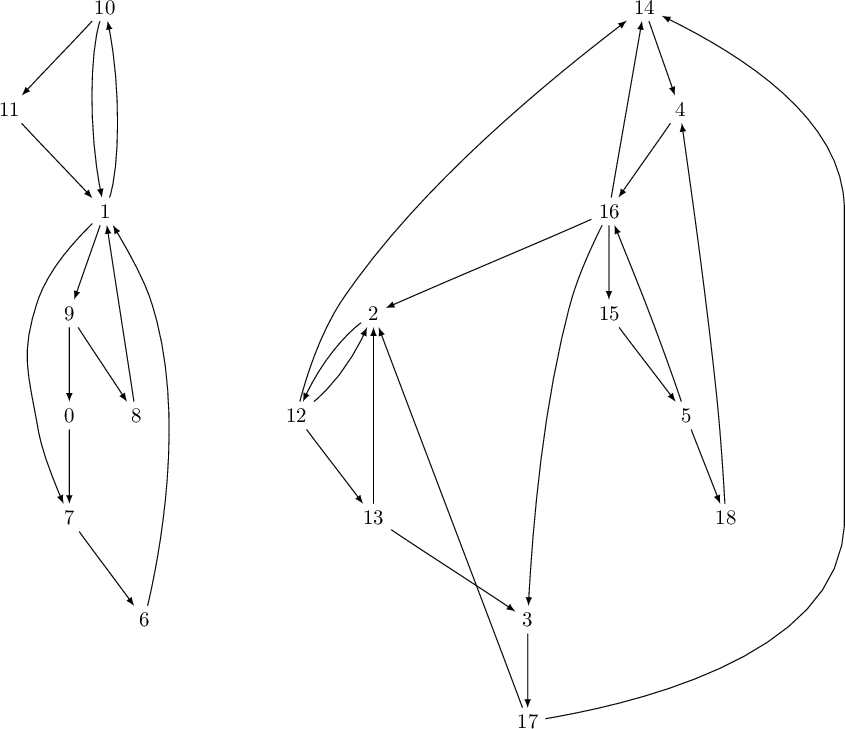

In [101]:
Gh = DiGraph(T12.dominoes_with_surrounding(i=1,radius=2), format='list_of_edges')
TikzPicture.from_graph(Gh)

## Vertical Rauzy graph for the tiles $\mathcal{T}_{12}$

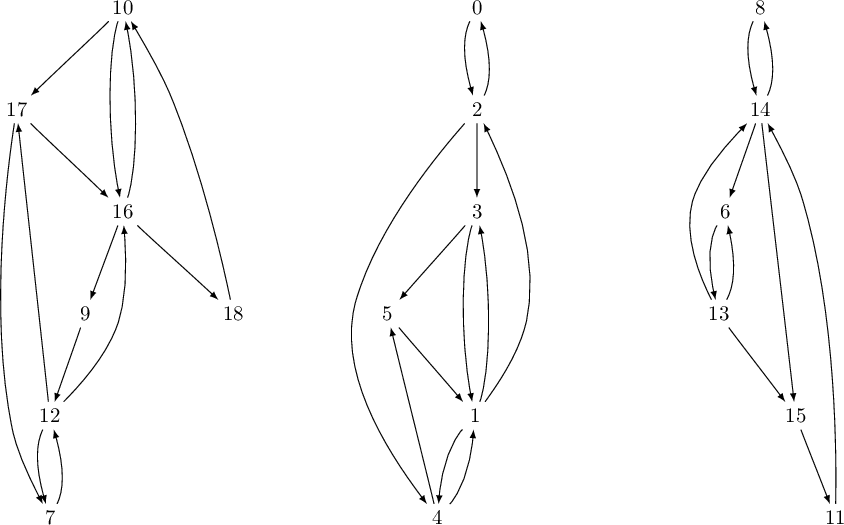

In [102]:
Gv = DiGraph(T12.dominoes_with_surrounding(i=2,radius=2), format='list_of_edges')
TikzPicture.from_graph(Gv)

## Frequencies of tiles in $\Omega_4$:

Inverse of frequencies of tiles in $\Omega_4$:

In [103]:
M = matrix(omegaUtoU)
z = polygen(QQ, 'z')
K.<phi> = NumberField(z**2-z-1, 'phi', embedding=RR(1.6))
MK = M.change_ring(K)
v = MK.eigenvectors_right()[0][1][0]
v4 = matrix(omega4toU) * v
sorted((1/a, i) for (i,a) in enumerate(v4/sum(v4)))

[(5*phi + 3, 14),
 (6*phi + 4, 22),
 (8*phi + 5, 10),
 (8*phi + 5, 19),
 (10*phi + 6, 3),
 (10*phi + 6, 5),
 (10*phi + 6, 6),
 (10*phi + 6, 13),
 (10*phi + 6, 21),
 (10*phi + 6, 24),
 (10*phi + 6, 25),
 (10*phi + 6, 26),
 (13*phi + 8, 18),
 (16*phi + 10, 0),
 (16*phi + 10, 1),
 (16*phi + 10, 4),
 (16*phi + 10, 12),
 (16*phi + 10, 15),
 (16*phi + 10, 20),
 (16*phi + 10, 23),
 (16*phi + 10, 27),
 (26*phi + 16, 2),
 (26*phi + 16, 8),
 (26*phi + 16, 9),
 (26*phi + 16, 11),
 (26*phi + 16, 17),
 (42*phi + 26, 7),
 (42*phi + 26, 16)]

## Frequencies of tiles in $\Omega_0$:

Inverse of frequencies of tiles in $\Omega_0$:

In [104]:
v0 = matrix(omega0to4) * v4
sorted((1/a, i) for (i,a) in enumerate(v0/sum(v0)))

[(12/5*phi + 14/5, 7),
 (2*phi + 6, 0),
 (2*phi + 6, 1),
 (2*phi + 6, 3),
 (2*phi + 6, 6),
 (2*phi + 6, 9),
 (5*phi + 4, 5),
 (8*phi + 2, 4),
 (8*phi + 2, 8),
 (8*phi + 2, 10),
 (18*phi + 10, 2)]